## Imports and Set Up

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import sklearn as sk
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn import metrics
from sklearn.metrics import recall_score, plot_confusion_matrix, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# SyriaTel Customer Churn Prediction
**Author:** Christopher Varghese

## Overview
For any business, especially services that are subscription based, it is important to maximize customer retention. The goal of this project was to predict if a customer was soon to churn by analyzing the data associated with customers that left or stayed with the service. Wether or not a customer would churn was expressed as a binary classification where the prediction would yield True if the customer was soon to churn and False if they weren't.

## Business and Data Understanding
Detecting if a customer is soon to churn can definitely increase customer retention rates provided there is a strategy to actually prevent them from churning. This may include offering them a promotion or exploring why they are churning and who they are seeking service from next.

The data is collected from SyriaTel, a telecom company. It was obtained as a csv file of 3,333 rows and 21(5 categorical and 16 numeric) columns. The column 'Churn' was isolated as the target where it was found to be True if the customer left and False if they stayed. The data was processed and the relationships between the features were examined while modelling.

## Data Cleaning

In [2]:
df = pd.read_csv('customer-churn.csv')
pd.set_option('display.max_columns', None)
df.shape
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [3]:
#check for null
df.apply(lambda x: sum(x.isnull()))

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [4]:
df.churn.value_counts(normalize = True)

False    0.855086
True     0.144914
Name: churn, dtype: float64

<AxesSubplot:>

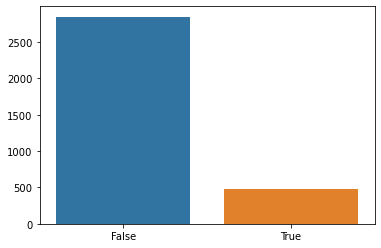

In [5]:
y = df["churn"].value_counts()
sns.barplot(x = y.index, y = y.values)

**Summary of Observations:**  
* 14.4% of customers do churn
* 85.6% of customers do not churn

Since we are concerned about the customers that did leave and only 15% of the customers from the data left, resampling may be helpful. We will also have to evaluate our models using recall. This is to measure the amount of false positives in our models which is the result we would like to avoid the most. In this case, a false positive is when we will predict a customer to stay with the service, when actually they are going to churn.

### Further Analysis and Cleaning

In [6]:
df.dtypes

state                      object
account length              int64
area code                   int64
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

* The Churn column is boolean so I will change this from boolean to int. 1 will represent True (cutomer did churn) and 0 will represent False (customer did not churn)
* International Plan and Voice Mail Plan are columns that need to be changed from string to int. 1 will represent 'yes' and 0 will represent 'no'.

In [7]:
df['international plan'].replace(('yes', 'no'), (1, 0), inplace = True)

In [8]:
df['voice mail plan'].replace(('yes', 'no'), (1, 0), inplace = True)

In [9]:
df['churn'] = df['churn'].astype(int)
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,0,1,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,OH,107,415,371-7191,0,1,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,NJ,137,415,358-1921,0,0,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,OH,84,408,375-9999,1,0,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,OK,75,415,330-6626,1,0,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


In [10]:
#Ensure all values where replaced correctly

#df['international plan'].value_counts(normalize = True)
#df['voice mail plan'].value_counts(normalize = True)
df['churn'].value_counts(normalize = True)

0    0.855086
1    0.144914
Name: churn, dtype: float64

<AxesSubplot:>

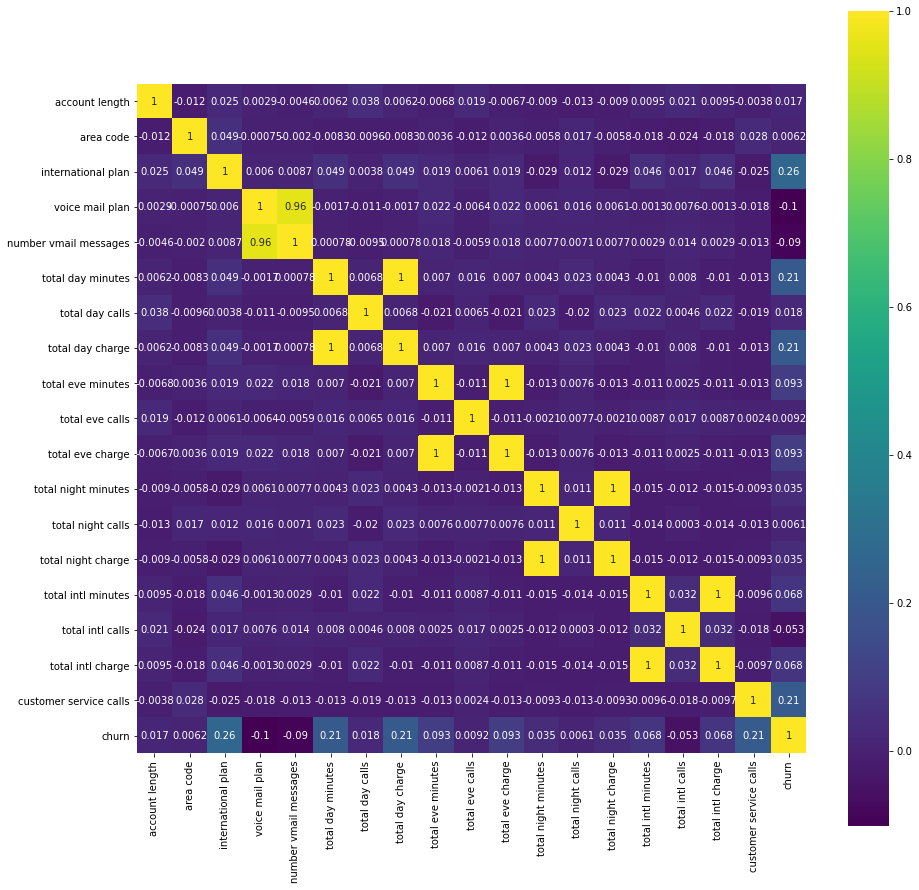

In [11]:
plt.figure(figsize=(15, 15))
sns.heatmap(df.corr(), vmax=1, square=True, annot=True, cmap='viridis')

From the correlation matrix, it is evident that these columns show similar information
* total day charge -> total day minutes
* total eve charge -> total eve minutes
* total night charge -> total night minutes
* total intl charge -> total intl minutes
This is likely because the total charge is derived from the total minutes for each period of the day. Therefore I will drop all the minutes columns.

The column 'voice mail plan' is also highly correlated with 'number vmail messages'. Since 'voice mail plan' has the higher correlation coefficient, I will drop the other column.

In [12]:
df.columns

Index(['state', 'account length', 'area code', 'phone number',
       'international plan', 'voice mail plan', 'number vmail messages',
       'total day minutes', 'total day calls', 'total day charge',
       'total eve minutes', 'total eve calls', 'total eve charge',
       'total night minutes', 'total night calls', 'total night charge',
       'total intl minutes', 'total intl calls', 'total intl charge',
       'customer service calls', 'churn'],
      dtype='object')

In [13]:
df.drop(['total day minutes', 'total eve minutes', 'total night minutes', 'total intl minutes'], inplace = True, axis = 1)

In [14]:
#plt.figure(figsize=(15, 15))
#sns.heatmap(df1.corr(), vmax=1, square=True, annot=True, cmap='viridis')

In [15]:
#filter out all non-numeric data and save to df1
df1 = df.select_dtypes('number')
#df1.head()

Further exploration may be necesary to increase correlation between values. Possible transformations need to be explored.

### Train Test Split
For this split I am setting aside X_test and y_test as data that will not be seen by the model until final testing. I am splitting the remaining data into a training set and a validation set. 

In [16]:
X = df1.drop('churn', axis=1)
y = df1['churn']

X_train_all, X_test, y_train_all, y_test = train_test_split(X, y, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, random_state=42)

## Base Model

Create baseline test for other experiments. Since we are analyizing a customer churn, the recall score metric is the most relevant. This is because a false negative in this case is predicting that a customer will stay(churn = false) when actually they will churn(churn = true). I will also assess the results using a confusion matrix.

In [17]:
base_model_reg = LogisticRegression(random_state=42)

In [18]:
base_model_reg.fit(X_train, y_train)

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

0.1015625


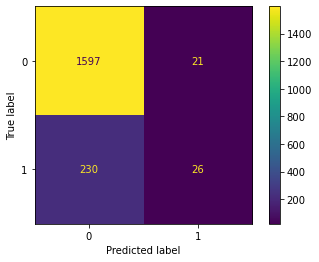

In [19]:
train_preds = base_model_reg.predict(X_train)
plot_confusion_matrix(base_model_reg, X_train, y_train)
score = recall_score(y_train, train_preds)
print(score)

0.049019607843137254


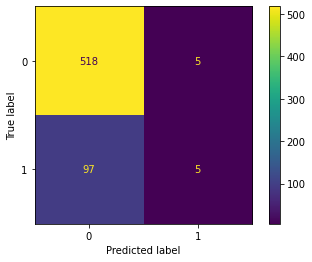

In [20]:
val_preds = base_model_reg.predict(X_val)
plot_confusion_matrix(base_model_reg, X_val, y_val)
score = recall_score(y_val, val_preds)
print(score)

In [21]:
cross_val_score(base_model_reg, X_train_all, y_train_all, scoring = 'recall')

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

array([0.05633803, 0.13888889, 0.04166667, 0.02777778, 0.05633803])

The base model with the raw data is only able to identify between 10% of the churning customers in the training data and 5% in the validation model. The cross validation shows the predicting power of the model to only be between 2.8% and 14% as well. The first steps I will take to correct this is by scaling, resampling, and further feature analysis.

## Scaling

Since the model is currently underfit, I will try scaling the features so that all features can equally affect the predicting power of the model. I will also try resampling the training set since this may be a class imbalance issue since the majority class has a weight of 85% while the minority class only has a weight of 15%

In [22]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [23]:
scaled_model_reg = LogisticRegression(random_state=42)
scaled_model_reg.fit(X_train_scaled, y_train)

LogisticRegression(random_state=42)

0.21484375


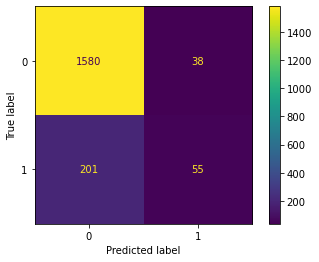

In [24]:
train_preds_scaled = scaled_model_reg.predict(X_train_scaled)
plot_confusion_matrix(scaled_model_reg, X_train_scaled, y_train)
score = recall_score(y_train, train_preds_scaled)
print(score)

0.1568627450980392


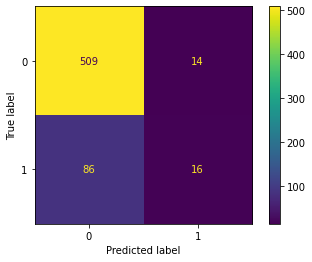

In [25]:
val_preds_scaled = scaled_model_reg.predict(X_val_scaled)
plot_confusion_matrix(scaled_model_reg, X_val_scaled, y_val)
score = recall_score(y_val, val_preds_scaled)
print(score)

In [26]:
scale = StandardScaler()
steps = [('Scaling', scale), ('scaled test', scaled_model_reg)]
scaled_pipe = Pipeline(steps = steps)
scaled_scores = cross_val_score(scaled_pipe, X_train_all, y_train_all, cv=5, scoring='recall')
print('average recall score: {}, from {}'.format(np.average(scaled_scores), scaled_scores))

average recall score: 0.19268388106416273, from [0.16901408 0.29166667 0.18055556 0.125      0.1971831 ]


Scaling the features improved the recall score from the base model greatly. The base model had a score of 10% and 5% for its training and testing iterations while the scaled model had a recall score of 21% and 16%. The cross validation is also improved with the lowest range being 12.5% and the highest being 30%.

## Resampling

In [27]:
resampler = SMOTE(random_state = 42)
X_resampled, y_resampled = resampler.fit_resample(X_train_scaled, y_train)

In [28]:
resampled_model_reg = LogisticRegression(random_state=42)
resampled_model_reg.fit(X_resampled, y_resampled)

LogisticRegression(random_state=42)

0.7750309023485785


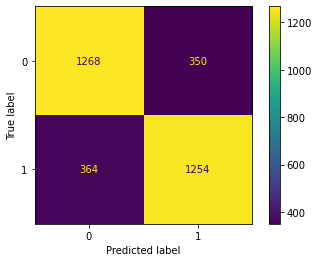

In [29]:
train_preds_resampled = resampled_model_reg.predict(X_resampled)
plot_confusion_matrix(resampled_model_reg, X_resampled, y_resampled)
score = recall_score(y_resampled, train_preds_resampled)
print(score)

0.7352941176470589


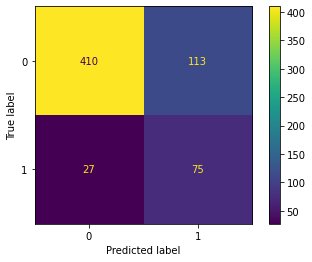

In [30]:
val_preds_resampled = resampled_model_reg.predict(X_val_scaled)
plot_confusion_matrix(resampled_model_reg, X_val_scaled, y_val)
score = recall_score(y_val, val_preds_resampled)
print(score)

In [31]:
#Without scaling
resample = SMOTE(random_state=42)
steps = [('SMOTE Resample', resample), ('Logistic Regression', resampled_model_reg)]
resampled_pipe = Pipeline(steps = steps)
resampled_scores = cross_val_score(resampled_pipe, X_train_all, y_train_all, cv=5, scoring='recall')
print('average recall score: {}, from {}'.format(np.average(resampled_scores), resampled_scores))

/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-

average recall score: 0.667605633802817, from [0.69014085 0.70833333 0.69444444 0.59722222 0.64788732]


/srv/conda/envs/notebook/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
#With scaling
steps = [('Scaling', scale),('SMOTE Resample', resample), ('Logistic Regression', resampled_model_reg)]
resampled_pipe = Pipeline(steps = steps)
resampled_scores = cross_val_score(resampled_pipe, X_train_all, y_train_all, cv=5, scoring='recall')
print('average recall score: {}, from {}'.format(np.average(resampled_scores), resampled_scores))

average recall score: 0.7235915492957745, from [0.71830986 0.76388889 0.68055556 0.68055556 0.77464789]


Resampling has improved the performance of the model drastically since it solves the class imbalance issue. The resampled data helps train the model that has a recall score of 72.4% on average in the cross val. Both resampling and scaling are necessary as the model only scores 66.8% when it is only resampled and not scaled. At this point the model may benefit from hypertuning, but I will focus on extracting more information from the features by filtering out noise. Then I will test the impact of changing these features on the logisitic regression model before moving on to more powerful models.

## Feature Exploration

In [33]:
#function to get new training splits that are scaled and resampled from a basic df. this will save time when experimenting
#adding and removing features
def get_splits(dataframe, whole = False):
    new_X = dataframe.drop('churn', axis=1)
    new_y = dataframe['churn']

    new_X_train_all, new_X_test, new_y_train_all, new_y_test = train_test_split(new_X, new_y, random_state=42)
    new_X_train, new_X_val, new_y_train, new_y_val = train_test_split(new_X_train_all, new_y_train_all, random_state=42)
    
    #scaling
    scaler = StandardScaler()
    scaler.fit(new_X_train)
    new_X_train_scaled = scaler.transform(new_X_train)
    new_X_val_scaled = scaler.transform(new_X_val)
    
    #resampling
    resampler = SMOTE(random_state = 42)
    new_X_resampled, new_y_resampled = resampler.fit_resample(new_X_train_scaled, new_y_train)
    if (whole):
        return new_X_train_all, new_y_train_all
    return new_X_resampled, new_y_resampled, new_X_val_scaled, new_y_val

In [34]:
# function to quickly plot confusion matrix and print out recall score
def plot_matrix(model, model_X, model_y):
    predictions = model.predict(model_X)
    plot_confusion_matrix(model, model_X, model_y)
    score = recall_score(model_y, predictions)
    print(score)

In [35]:
#this is the current cleaned data
df1.head()

,account length,area code,international plan,voice mail plan,number vmail messages,total day calls,total day charge,total eve calls,total eve charge,total night calls,total night charge,total intl calls,total intl charge,customer service calls,churn
0,128,415,0,1,25,110,45.07,99,16.78,91,11.01,3,2.70,1,0
1,107,415,0,1,26,123,27.47,103,16.62,103,11.45,3,3.70,1,0
2,137,415,0,0,0,114,41.38,110,10.30,104,7.32,5,3.29,0,0
3,84,408,1,0,0,71,50.90,88,5.26,89,8.86,7,1.78,2,0
4,75,415,1,0,0,113,28.34,122,12.61,121,8.41,3,2.73,3,0


### Customer Service Calls
Does the number of customer service calls have an impact on the number of customer that churn?

<AxesSubplot:xlabel='churn', ylabel='customer service calls'>

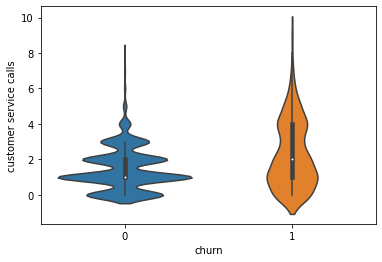

In [36]:
sns.violinplot(x = 'churn', y = 'customer service calls', data = df1, kind = 'box')

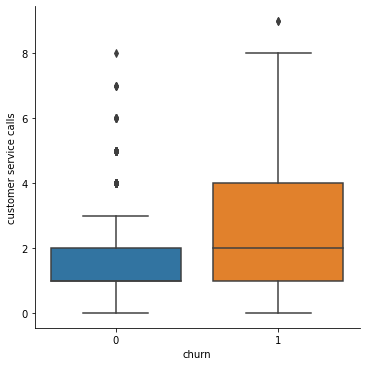

In [37]:
sns.catplot(x = 'churn', y = 'customer service calls', data = df1, kind = 'box')

This violin plot shows us that customers that do churn definitely do use the customer service calls more frequently than others but the overlap is too great. We must consider the number of customer service calls along with more information. The boxplot shows that majority of the customers that do not churn are centered at only 1 customer service call. The issue is that 50% of the distribution of non churning customers overlaps with 50% of the distribution of customers that do not churn, so isolating this overlap would likely improve the model

### Account Length
what impact does account length have on a customer churning?

<AxesSubplot:xlabel='churn', ylabel='account length'>

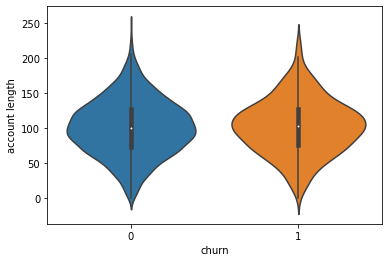

In [45]:
sns.violinplot(x = 'churn', y = 'account length', data = df1, kind = 'box')

The distributions for account length are nearly identical for customer that churn and do not churn, which suggests it may not be a very good indicator, we will test the impact of dropping this feature.

In [46]:
X_train_acl, y_train_acl, X_val_acl, y_val_acl = get_splits(df1.drop(['account length'], axis = 1))
no_acl_model_reg = LogisticRegression(random_state=42)
no_acl_model_reg.fit(X_train_acl, y_train_acl)

LogisticRegression(random_state=42)

0.7731767614338689


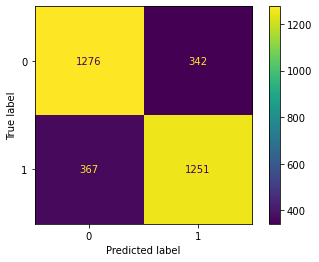

In [47]:
plot_matrix(no_acl_model_reg, X_train_acl, y_train_acl)

0.7450980392156863


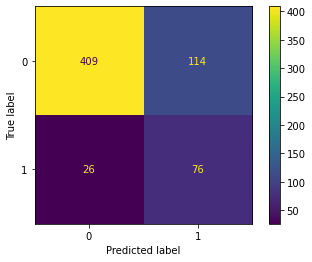

In [48]:
plot_matrix(no_acl_model_reg, X_val_acl, y_val_acl)

In [49]:
#old
cross_val_score(resampled_pipe, X_train_all, y_train_all, cv=5, scoring='recall')

array([0.71830986, 0.76388889, 0.68055556, 0.68055556, 0.77464789])

In [76]:
#new
steps = [('Scaling', scale),('SMOTE Resample', resample), ('acclen test', cs_model_reg)]
acl_pipe = Pipeline(steps = steps)

#get training sets with customer service column dropped
acl_X_train_all, acl_y_train_all = get_splits(df1.drop(['account length'], axis = 1), whole = True)

cross_val_score(acl_pipe, acl_X_train_all, acl_y_train_all, cv=5, scoring='recall')

array([0.71830986, 0.76388889, 0.69444444, 0.66666667, 0.74647887])

By some small amount, it seems dropping this column causes the scores to slightly decrease, so we will keep account length as a feature

## Further Modeling
We will test out the performance of other models since this is a solution to improving the current prediction power. First we will test the K-Nearest-Neighbors model, and then we will test the Random Forest model

### KNN

In [59]:
knn_model = KNeighborsClassifier(n_neighbors=5)
# fit the model
knn_model.fit(X_resampled, y_resampled)

KNeighborsClassifier()

0.9969097651421508

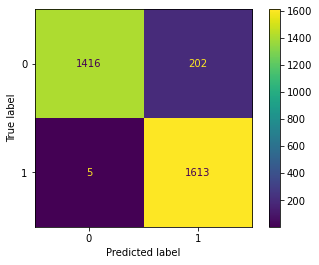

In [60]:
plot_confusion_matrix(knn_model, X_resampled, y_resampled)
predicted = knn_model.predict(X_resampled)
recall_score(y_resampled, predicted)

0.6470588235294118

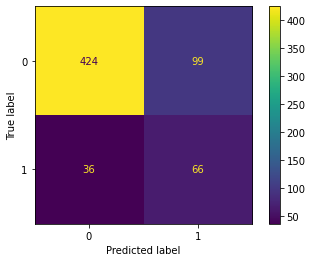

In [61]:
plot_confusion_matrix(knn_model, X_val_scaled, y_val)
val_predicted = knn_model.predict(X_val_scaled)
recall_score(y_val, val_predicted)

In [62]:
#old
cross_val_score(resampled_pipe, X_train_all, y_train_all, cv=5, scoring='recall')

array([0.71830986, 0.76388889, 0.68055556, 0.68055556, 0.77464789])

In [63]:
#new
steps = [('Scaling', scale),('SMOTE Resample', resample), ('knn test', knn_model)]
knn_pipe = Pipeline(steps = steps)
cross_val_score(knn_pipe, X_train_all, y_train_all, cv=5, scoring='recall')

array([0.67605634, 0.73611111, 0.72222222, 0.66666667, 0.71830986])

KNN model seems worse than logistic regression model right now, so we will try improving the model by changing the parameters

### KNN - Hypertuning

I will begin by comparing how the recall scores change for the model with training and testing data for each value of k.

In [80]:
max_recall = 0;
best_k = 0
for k in range (1,50):
    #creating model with param k
    knn_model_temp = KNeighborsClassifier(n_neighbors=k)
    #cross validation
    steps = [('Scaling', scale),('SMOTE Resample', resample), ('knn test', knn_model_temp)]
    knn_pipe_test = Pipeline(steps = steps)
    test_scores = cross_val_score(knn_pipe_test, X_train_all, y_train_all, cv=5, scoring='recall')
    print('Recall Scores for value of k = {} are: {}, avg = {}'.format(k, test_scores, np.average(test_scores)))
    if (np.average(test_scores) > max_recall):
        max_recall = np.average(test_scores)
        best_k = k
print('The best k was {} with a average recall score of {}'.format(best_k, max_recall))

Recall Scores for value of k = 1 are: [0.50704225 0.56944444 0.52777778 0.48611111 0.50704225], avg = 0.5194835680751174
Recall Scores for value of k = 2 are: [0.3943662  0.47222222 0.48611111 0.43055556 0.46478873], avg = 0.44960876369327074
Recall Scores for value of k = 3 are: [0.6056338  0.69444444 0.61111111 0.625      0.64788732], avg = 0.6368153364632237
Recall Scores for value of k = 4 are: [0.54929577 0.69444444 0.55555556 0.55555556 0.63380282], avg = 0.5977308294209702
Recall Scores for value of k = 5 are: [0.67605634 0.73611111 0.72222222 0.66666667 0.71830986], avg = 0.7038732394366197
Recall Scores for value of k = 6 are: [0.64788732 0.70833333 0.68055556 0.65277778 0.71830986], avg = 0.6815727699530517
Recall Scores for value of k = 7 are: [0.74647887 0.79166667 0.76388889 0.72222222 0.77464789], avg = 0.7597809076682316
Recall Scores for value of k = 8 are: [0.67605634 0.75       0.73611111 0.69444444 0.73239437], avg = 0.7178012519561815
Recall Scores for value of k = 

From the experiments, the k values of 21, 23, 25, and 27 seem to have the highest recall scores. After running all options from 1-50, we see that the recall scores are also high at k=45 and k=47, but the recall scores for the actual training data go down. I will most likely use a k value of 27 since this gives me the highest recall score.

After testing out all possible values of k from 1 to 50, it was determined that a k of 33 yields the lowest recall score, which is an average of 82.3% in the cross validation. So far this is the best model so we will compare it to the current best model at this point which is the logistic regression model.

In [81]:
knn_model_2 = KNeighborsClassifier(n_neighbors=33)
# fit the model
knn_model_2.fit(X_resampled, y_resampled)

KNeighborsClassifier(n_neighbors=33)

0.9363411619283065

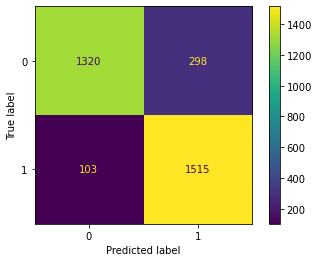

In [84]:
plot_confusion_matrix(knn_model_2, X_resampled, y_resampled)
predicted = knn_model_2.predict(X_resampled)
recall_score(y_resampled, predicted)

0.7647058823529411

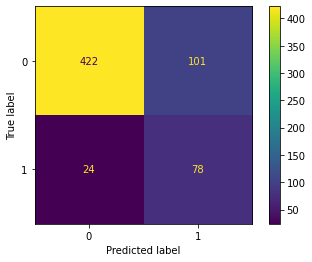

In [85]:
plot_confusion_matrix(knn_model_2, X_val_scaled, y_val)
val_predicted = knn_model_2.predict(X_val_scaled)
recall_score(y_val, val_predicted)

In [86]:
#old
logr_scores = cross_val_score(resampled_pipe, X_train_all, y_train_all, cv=5, scoring='recall')
print('average recall score: {}, from {}'.format(np.average(logr_scores), logr_scores))

average recall score: 0.7235915492957745, from [0.71830986 0.76388889 0.68055556 0.68055556 0.77464789]


In [87]:
#new
steps = [('Scaling', scale),('SMOTE Resample', resample), ('knn test', knn_model_2)]
knn_pipe_2 = Pipeline(steps = steps)
knn_scores = cross_val_score(knn_pipe_2, X_train_all, y_train_all, cv=5, scoring='recall')
print('average recall score: {}, from {}'.format(np.average(knn_scores), knn_scores))

average recall score: 0.8127543035993741, from [0.71830986 0.84722222 0.83333333 0.79166667 0.87323944]


This model is definitely better than the current best iteration of the logisitic regression model so this will be the new model to surpass.

### Random Forest
This is a basic implementation of the random forest model with scaling and resampling.

In [71]:
rf = RandomForestClassifier(random_state=42)    
# Fit
rf_model = rf.fit(X_resampled, y_resampled)

1.0

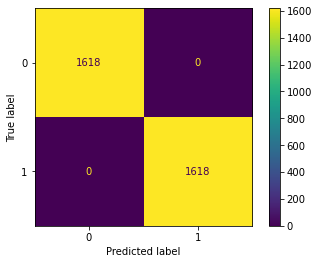

In [72]:
plot_confusion_matrix(rf_model, X_resampled, y_resampled)
predicted = rf_model.predict(X_resampled)
recall_score(y_resampled, predicted)

0.7058823529411765

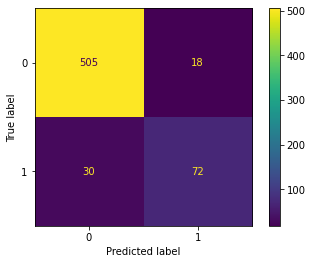

In [73]:
plot_confusion_matrix(rf_model, X_val_scaled, y_val)
val_predicted = rf_model.predict(X_val_scaled)
recall_score(y_val, val_predicted)

In [74]:
print('average logr recall score: {}, from {}'.format(np.average(logr_scores), logr_scores))
print('average knn recall score: {}, from {}'.format(np.average(knn_scores), knn_scores))

average logr recall score: 0.7235915492957745, from [0.71830986 0.76388889 0.68055556 0.68055556 0.77464789]
average knn recall score: 0.8071596244131456, from [0.71830986 0.84722222 0.83333333 0.77777778 0.85915493]


In [88]:
#new
steps = [('Scaling', scale),('SMOTE Resample', resample), ('rf test', rf_model)]
rf_pipe = Pipeline(steps = steps)
rf_scores = cross_val_score(rf_pipe, X_train_all, y_train_all, cv=5, scoring='recall')
print('average rf recall score: {}, from {}'.format(np.average(rf_scores), rf_scores))

average rf recall score: 0.7345461658841941, from [0.69014085 0.75       0.77777778 0.70833333 0.74647887]


This model is slightly better than the best logistic regression model but is not as powerful as the best KNN model so far. It is possible that the random forest model may benefit from hypertuning but the current KNN model will be our final model at this point.

## Final Testing
For the final round of testing we will use the unseen test data. First I will train the model on the entire training data set and then predict all of the unseen testing data. Then I will do a cross validation using the entirety of the data.

In [91]:
#fitting final model through pipeline
final_model = KNeighborsClassifier(n_neighbors=33)
steps = [('Scaling', scale),('SMOTE Resample', resample), ('KNN Model', final_model)]
final_pipe = Pipeline(steps = steps)
final_pipe.fit(X_train_all, y_train_all)

Pipeline(steps=[('Scaling', StandardScaler()),
                ('SMOTE Resample', SMOTE(random_state=42)),
                ('KNN Model', KNeighborsClassifier(n_neighbors=33))])

0.9022346368715084

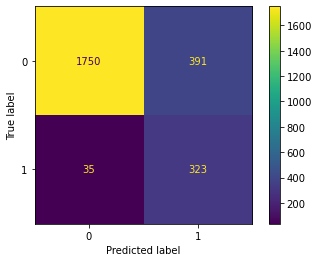

In [95]:
#confusion matrix for trained data
plot_confusion_matrix(final_pipe, X_train_all, y_train_all)
predicted = final_pipe.predict(X_train_all)
recall_score(y_train_all, predicted)

0.872

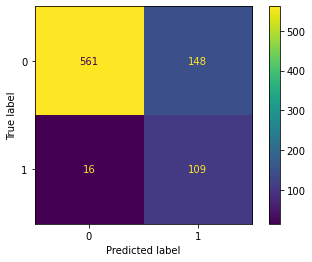

In [104]:
#confusion matrix for unseen testing data
plot_confusion_matrix(final_pipe, X_test, y_test)
predicted = final_pipe.predict(X_test)
recall_score(y_test, predicted)

In [99]:
final_scores = cross_val_score(final_pipe, X, y, cv=5, scoring='recall')
print('average rf recall score: {}, from {}'.format(np.average(final_scores), final_scores))

average rf recall score: 0.8219716494845362, from [0.79381443 0.78350515 0.87628866 0.83333333 0.82291667]


## Conclusions and Next Steps
After training the model with all of the training data, the model preformed with a recall acuracy of 87.2% on the unseen test data. This means that we are able to predict 87.2% of the customers that are soon to churn. The cross validation also yielded a high recall score of 82.2% on average with recall scores ranging from 78.4% to 87.6% on the 5 splits.

Although this is a high performing model, there are improvements that can be made. Further tuning of the Random Forest model and more feature engineering may yield some improvement.

While this model is only able to predict customers that are soon to churn, it has no effect on wether these customers will churn or not. The next steps would be to implement various strategies for customer retention such as directly intervening with customers that are flagged by the model as soon to churn. If a successful strategy is implemented, SyriaTel may be capable of decreasing their churn rate which is currently 15%. Since the model currently does flag some customers that are not churning as soon to churn, it is important to evaluate a the costs and benefits of providing every customer that is flagged for churning a certain promotion or some kind of incentive not to churn. Finally, a secondary model can be explored after the business begins implementing various customer retention strategies to determine which strategies work and on which customers it has the highest probability of working on.